In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import math

%matplotlib inline

In [2]:
# Susceptible, Exposed, Infected_Symptomatic, Infected_Asymptomatic, Recovered
init_pop = {
    'Central_High': [234144, 1, 1, 1, 0],
    'Central_Low': [277516, 0, 0, 0, 0],
    'East_High': [249102, 0, 0, 0, 0],
    'East_Low': [239228, 0, 0, 0, 0],
    'North_Central_High': [175301, 0, 0, 0, 0],
    'North_Central_Low': [471079, 0, 0, 0, 0],
    'North_Coastal_High': [159507, 0, 0, 0, 0],
    'North_Coastal_Low': [375712, 0, 0, 0, 0],
    'North_Inland_High': [195235, 0, 0, 0, 0],
    'North_Inland_Low': [406765, 0, 0, 0, 0],
    'South_High': [212538, 0, 0, 0, 0],
    'South_Low': [287538, 0, 0, 0, 0]
}

In [3]:
# Central High Risk
S_H_C, E_H_C, I_H_C, A_H_C, R_H_C = init_pop['Central_High'][0],\
                                    init_pop['Central_High'][1],\
                                    init_pop['Central_High'][2],\
                                    init_pop['Central_High'][3],\
                                    init_pop['Central_High'][4]

# Central Low Risk
S_L_C, E_L_C, I_L_C, A_L_C, R_L_C = init_pop['Central_Low'][0],\
                                    init_pop['Central_Low'][1],\
                                    init_pop['Central_Low'][2],\
                                    init_pop['Central_Low'][3],\
                                    init_pop['Central_Low'][4]

# East High Risk
S_H_E, E_H_E, I_H_E, A_H_E, R_H_E = init_pop['East_High'][0],\
                                    init_pop['East_High'][1],\
                                    init_pop['East_High'][2],\
                                    init_pop['East_High'][3],\
                                    init_pop['East_High'][4]

# East Low Risk
S_L_E, E_L_E, I_L_E, A_L_E, R_L_E = init_pop['East_Low'][0],\
                                    init_pop['East_Low'][1],\
                                    init_pop['East_Low'][2],\
                                    init_pop['East_Low'][3],\
                                    init_pop['East_Low'][4]

# North Central High Risk
S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen = init_pop['North_Central_High'][0],\
                                                   init_pop['North_Central_High'][1],\
                                                   init_pop['North_Central_High'][2],\
                                                   init_pop['North_Central_High'][3],\
                                                   init_pop['North_Central_High'][4]

# North Central Low Risk
S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen =  init_pop['North_Central_Low'][0],\
                                                    init_pop['North_Central_Low'][1],\
                                                    init_pop['North_Central_Low'][2],\
                                                    init_pop['North_Central_Low'][3],\
                                                    init_pop['North_Central_Low'][4]

# North Coastal High Risk
S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa =  init_pop['North_Coastal_High'][0],\
                                                    init_pop['North_Coastal_High'][1],\
                                                    init_pop['North_Coastal_High'][2],\
                                                    init_pop['North_Coastal_High'][3],\
                                                    init_pop['North_Coastal_High'][4]

# North Coastal Low Risk
S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa =  init_pop['North_Coastal_Low'][0],\
                                                    init_pop['North_Coastal_Low'][1],\
                                                    init_pop['North_Coastal_Low'][2],\
                                                    init_pop['North_Coastal_Low'][3],\
                                                    init_pop['North_Coastal_Low'][4]

# North Inland High Risk
S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI =  init_pop['North_Inland_High'][0],\
                                          init_pop['North_Inland_High'][1],\
                                          init_pop['North_Inland_High'][2],\
                                          init_pop['North_Inland_High'][3],\
                                          init_pop['North_Inland_High'][4]

# North Inland Low Risk
S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI =  init_pop['North_Inland_Low'][0],\
                                          init_pop['North_Inland_Low'][1],\
                                          init_pop['North_Inland_Low'][2],\
                                          init_pop['North_Inland_Low'][3],\
                                          init_pop['North_Inland_Low'][4]

# South High Risk
S_H_S, E_H_S, I_H_S, A_H_S, R_H_S = init_pop['South_High'][0],\
                                    init_pop['South_High'][1],\
                                    init_pop['South_High'][2],\
                                    init_pop['South_High'][3],\
                                    init_pop['South_High'][4]

# South Low Risk
S_L_S, E_L_S, I_L_S, A_L_S, R_L_S = init_pop['South_Low'][0],\
                                    init_pop['South_Low'][1],\
                                    init_pop['South_Low'][2],\
                                    init_pop['South_Low'][3],\
                                    init_pop['South_Low'][4]

In [4]:
param_dict = {
    'High': [0.4e-6, 0.2e-6, 1/5, 0.4, 1/14, 0.001],
    'Low': [0.4e-6, 0.2e-6, 1/5, 0.4, 1/14, 0.001],
}

beta_symp = param_dict['High'][0]
beta_asym = param_dict['High'][1]
gamma = param_dict['High'][2]
theta = param_dict['High'][3]
lamb = param_dict['High'][4]
delta = param_dict['High'][5]

In [5]:
df_Central_High = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])
df_Central_Low = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])

df_East_High = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])
df_East_Low = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])

df_North_Central_High = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])
df_North_Central_Low = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])

df_North_Coastal_High = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])
df_North_Coastal_Low = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])

df_North_Inland_High = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])
df_North_Inland_Low = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])

df_South_High = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])
df_South_Low = pd.DataFrame(columns=['Day', 'S', 'E', 'I', 'A', 'R'])

# add initial values to the dataframe
df_Central_High.loc[0] = [1, S_H_C, E_H_C, I_H_C, A_H_C, R_H_C]
df_Central_Low.loc[0] = [1, S_L_C, E_L_C, I_L_C, A_L_C, R_L_C]

df_East_High.loc[0] = [1, S_H_E, E_H_E, I_H_E, A_H_E, R_H_E]
df_East_Low.loc[0] = [1, S_L_E, E_L_E, I_L_E, A_L_E, R_L_E]

df_North_Central_High.loc[0] = [1, S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen]
df_North_Central_Low.loc[0] = [1, S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen]

df_North_Coastal_High.loc[0] = [1, S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa]
df_North_Coastal_Low.loc[0] = [1, S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa]

df_North_Inland_High.loc[0] = [1, S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI]
df_North_Inland_Low.loc[0] = [1, S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI]

df_South_High.loc[0] = [1, S_H_S, E_H_S, I_H_S, A_H_S, R_H_S]
df_South_Low.loc[0] = [1, S_L_S, E_L_S, I_L_S, A_L_S, R_L_S]

In [6]:
t = 1000

for day in range(t+1):

    # Generate mean SEIAR
    my_generator = np.random.default_rng()

    Central_High = { 'S_to_E': my_generator.binomial(S_H_C, (beta_symp * I_H_C) + (beta_asym * A_H_C)),
                     'E_to_I': my_generator.binomial(E_H_C, gamma*theta),
                     'E_to_A': my_generator.binomial(E_H_C, gamma*(1-theta)),
                     'I_to_R': my_generator.binomial(I_H_C, delta + lamb),
                     'A_to_R': my_generator.binomial(A_H_C, delta) }

    Central_Low = { 'S_to_E': my_generator.binomial(S_L_C, (beta_symp * I_L_C) + (beta_asym * A_L_C)),
                    'E_to_I': my_generator.binomial(E_L_C, gamma*theta),
                    'E_to_A': my_generator.binomial(E_L_C, gamma*(1-theta)),
                    'I_to_R': my_generator.binomial(I_L_C, delta + lamb),
                    'A_to_R': my_generator.binomial(A_L_C, delta) }

    East_High = { 'S_to_E': my_generator.binomial(S_H_E, (beta_symp * I_H_E) + (beta_asym * A_H_E)),
                  'E_to_I': my_generator.binomial(E_H_E, gamma*theta),
                  'E_to_A': my_generator.binomial(E_H_E, gamma*(1-theta)),
                  'I_to_R': my_generator.binomial(I_H_E, delta + lamb),
                  'A_to_R': my_generator.binomial(A_H_E, delta) }

    East_Low = {    'S_to_E': my_generator.binomial(S_L_E, (beta_symp * I_L_E) + (beta_asym * A_L_E)),
                    'E_to_I': my_generator.binomial(E_L_E, gamma*theta),
                    'E_to_A': my_generator.binomial(E_L_E, gamma*(1-theta)),
                    'I_to_R': my_generator.binomial(I_L_E, delta + lamb),
                    'A_to_R': my_generator.binomial(A_L_E, delta) }
    
    North_Central_High = {  'S_to_E': my_generator.binomial(S_H_NCen, (beta_symp * I_H_NCen) + (beta_asym * A_H_NCen)),
                            'E_to_I': my_generator.binomial(E_H_NCen, gamma*theta),
                            'E_to_A': my_generator.binomial(E_H_NCen, gamma*(1-theta)),
                            'I_to_R': my_generator.binomial(I_H_NCen, delta + lamb),
                            'A_to_R': my_generator.binomial(A_H_NCen, delta) }
    
    North_Central_Low = {   'S_to_E': my_generator.binomial(S_L_NCen, (beta_symp * I_L_NCen) + (beta_asym * A_L_NCen)),
                            'E_to_I': my_generator.binomial(E_L_NCen, gamma*theta),
                            'E_to_A': my_generator.binomial(E_L_NCen, gamma*(1-theta)),
                            'I_to_R': my_generator.binomial(I_L_NCen, delta + lamb),
                            'A_to_R': my_generator.binomial(A_L_NCen, delta) }

    North_Coastal_High = {  'S_to_E': my_generator.binomial(S_H_NCoa, (beta_symp * I_H_NCoa) + (beta_asym * A_H_NCoa)),
                            'E_to_I': my_generator.binomial(E_H_NCoa, gamma*theta),
                            'E_to_A': my_generator.binomial(E_H_NCoa, gamma*(1-theta)),
                            'I_to_R': my_generator.binomial(I_H_NCoa, delta + lamb),
                            'A_to_R': my_generator.binomial(A_H_NCoa, delta) }
    
    North_Coastal_Low = {   'S_to_E': my_generator.binomial(S_L_NCoa, (beta_symp * I_L_NCoa) + (beta_asym * A_L_NCoa)),
                            'E_to_I': my_generator.binomial(E_L_NCoa, gamma*theta),
                            'E_to_A': my_generator.binomial(E_L_NCoa, gamma*(1-theta)),
                            'I_to_R': my_generator.binomial(I_L_NCoa, delta + lamb),
                            'A_to_R': my_generator.binomial(A_L_NCoa, delta) }
    
    North_Inland_High = {   'S_to_E': my_generator.binomial(S_H_NI, (beta_symp * I_H_NI) + (beta_asym * A_H_NI)),
                            'E_to_I': my_generator.binomial(E_H_NI, gamma*theta),
                            'E_to_A': my_generator.binomial(E_H_NI, gamma*(1-theta)),
                            'I_to_R': my_generator.binomial(I_H_NI, delta + lamb),
                            'A_to_R': my_generator.binomial(A_H_NI, delta) }

    North_Inland_Low = {    'S_to_E': my_generator.binomial(S_L_NI, (beta_symp * I_L_NI) + (beta_asym * A_L_NI)),
                            'E_to_I': my_generator.binomial(E_L_NI, gamma*theta),
                            'E_to_A': my_generator.binomial(E_L_NI, gamma*(1-theta)),
                            'I_to_R': my_generator.binomial(I_L_NI, delta + lamb),
                            'A_to_R': my_generator.binomial(A_L_NI, delta) }
    
    South_High = {  'S_to_E': my_generator.binomial(S_H_S, (beta_symp * I_H_S) + (beta_asym * A_H_S)),
                    'E_to_I': my_generator.binomial(E_H_S, gamma*theta),
                    'E_to_A': my_generator.binomial(E_H_S, gamma*(1-theta)),
                    'I_to_R': my_generator.binomial(I_H_S, delta + lamb),
                    'A_to_R': my_generator.binomial(A_H_S, delta) }

    South_Low = {   'S_to_E': my_generator.binomial(S_L_S, (beta_symp * I_L_S) + (beta_asym * A_L_S)),
                    'E_to_I': my_generator.binomial(E_L_S, gamma*theta),
                    'E_to_A': my_generator.binomial(E_L_S, gamma*(1-theta)),
                    'I_to_R': my_generator.binomial(I_L_S, delta + lamb),
                    'A_to_R': my_generator.binomial(A_L_S, delta) }
                    
    # Compute new SEIAR
    Central_High_S_new = max(S_H_C - Central_High['S_to_E'], 0)
    Central_High_E_new = max(E_H_C + Central_High['S_to_E'] - Central_High['E_to_I'] - Central_High['E_to_A'], 0)
    Central_High_I_new = max(I_H_C + Central_High['E_to_I'] - Central_High['I_to_R'], 0)
    Central_High_A_new = max(A_H_C + Central_High['E_to_A'] - Central_High['A_to_R'], 0)
    Central_High_R_new = max(R_H_C + Central_High['I_to_R'] + Central_High['A_to_R'], 0)

    Central_Low_S_new = max(S_L_C - Central_Low['S_to_E'], 0)
    Central_Low_E_new = max(E_L_C + Central_Low['S_to_E'] - Central_Low['E_to_I'] - Central_Low['E_to_A'], 0)
    Central_Low_I_new = max(I_L_C + Central_Low['E_to_I'] - Central_Low['I_to_R'], 0)
    Central_Low_A_new = max(A_L_C + Central_Low['E_to_A'] - Central_Low['A_to_R'], 0)
    Central_Low_R_new = max(R_L_C + Central_Low['I_to_R'] + Central_Low['A_to_R'], 0)

    East_High_S_new = max(S_H_E - East_High['S_to_E'], 0)
    East_High_E_new = max(E_H_E + East_High['S_to_E'] - East_High['E_to_I'] - East_High['E_to_A'], 0)
    East_High_I_new = max(I_H_E + East_High['E_to_I'] - East_High['I_to_R'], 0)
    East_High_A_new = max(A_H_E + East_High['E_to_A'] - East_High['A_to_R'], 0)
    East_High_R_new = max(R_H_E + East_High['I_to_R'] + East_High['A_to_R'], 0)

    East_Low_S_new = max(S_L_E - East_Low['S_to_E'], 0)
    East_Low_E_new = max(E_L_E + East_Low['S_to_E'] - East_Low['E_to_I'] - East_Low['E_to_A'], 0)
    East_Low_I_new = max(I_L_E + East_Low['E_to_I'] - East_Low['I_to_R'], 0)
    East_Low_A_new = max(A_L_E + East_Low['E_to_A'] - East_Low['A_to_R'], 0)
    East_Low_R_new = max(R_L_E + East_Low['I_to_R'] + East_Low['A_to_R'], 0)

    North_Central_High_S_new = max(S_H_NCen - North_Central_High['S_to_E'], 0)
    North_Central_High_E_new = max(E_H_NCen + North_Central_High['S_to_E'] - North_Central_High['E_to_I'] - North_Central_High['E_to_A'], 0)
    North_Central_High_I_new = max(I_H_NCen + North_Central_High['E_to_I'] - North_Central_High['I_to_R'], 0)
    North_Central_High_A_new = max(A_H_NCen + North_Central_High['E_to_A'] - North_Central_High['A_to_R'], 0)
    North_Central_High_R_new = max(R_H_NCen + North_Central_High['I_to_R'] + North_Central_High['A_to_R'], 0)

    North_Central_Low_S_new = max(S_L_NCen - North_Central_Low['S_to_E'], 0)
    North_Central_Low_E_new = max(E_L_NCen + North_Central_Low['S_to_E'] - North_Central_Low['E_to_I'] - North_Central_Low['E_to_A'], 0)
    North_Central_Low_I_new = max(I_L_NCen + North_Central_Low['E_to_I'] - North_Central_Low['I_to_R'], 0)
    North_Central_Low_A_new = max(A_L_NCen + North_Central_Low['E_to_A'] - North_Central_Low['A_to_R'], 0)
    North_Central_Low_R_new = max(R_L_NCen + North_Central_Low['I_to_R'] + North_Central_Low['A_to_R'], 0)

    North_Coastal_High_S_new = max(S_H_NCoa - North_Coastal_High['S_to_E'], 0)
    North_Coastal_High_E_new = max(E_H_NCoa + North_Coastal_High['S_to_E'] - North_Coastal_High['E_to_I'] - North_Coastal_High['E_to_A'], 0)
    North_Coastal_High_I_new = max(I_H_NCoa + North_Coastal_High['E_to_I'] - North_Coastal_High['I_to_R'], 0)
    North_Coastal_High_A_new = max(A_H_NCoa + North_Coastal_High['E_to_A'] - North_Coastal_High['A_to_R'], 0)
    North_Coastal_High_R_new = max(R_H_NCoa + North_Coastal_High['I_to_R'] + North_Coastal_High['A_to_R'], 0)

    North_Coastal_Low_S_new = max(S_L_NCoa - North_Coastal_Low['S_to_E'], 0)
    North_Coastal_Low_E_new = max(E_L_NCoa + North_Coastal_Low['S_to_E'] - North_Coastal_Low['E_to_I'] - North_Coastal_Low['E_to_A'], 0)
    North_Coastal_Low_I_new = max(I_L_NCoa + North_Coastal_Low['E_to_I'] - North_Coastal_Low['I_to_R'], 0)
    North_Coastal_Low_A_new = max(A_L_NCoa + North_Coastal_Low['E_to_A'] - North_Coastal_Low['A_to_R'], 0)
    North_Coastal_Low_R_new = max(R_L_NCoa + North_Coastal_Low['I_to_R'] + North_Coastal_Low['A_to_R'], 0)

    North_Inland_High_S_new = max(S_H_NI - North_Inland_High['S_to_E'], 0)
    North_Inland_High_E_new = max(E_H_NI + North_Inland_High['S_to_E'] - North_Inland_High['E_to_I'] - North_Inland_High['E_to_A'], 0)
    North_Inland_High_I_new = max(I_H_NI + North_Inland_High['E_to_I'] - North_Inland_High['I_to_R'], 0)
    North_Inland_High_A_new = max(A_H_NI + North_Inland_High['E_to_A'] - North_Inland_High['A_to_R'], 0)
    North_Inland_High_R_new = max(R_H_NI + North_Inland_High['I_to_R'] + North_Inland_High['A_to_R'], 0)

    North_Inland_Low_S_new = max(S_L_NI - North_Inland_Low['S_to_E'], 0)
    North_Inland_Low_E_new = max(E_L_NI + North_Inland_Low['S_to_E'] - North_Inland_Low['E_to_I'] - North_Inland_Low['E_to_A'], 0)
    North_Inland_Low_I_new = max(I_L_NI + North_Inland_Low['E_to_I'] - North_Inland_Low['I_to_R'], 0)
    North_Inland_Low_A_new = max(A_L_NI + North_Inland_Low['E_to_A'] - North_Inland_Low['A_to_R'], 0)
    North_Inland_Low_R_new = max(R_L_NI + North_Inland_Low['I_to_R'] + North_Inland_Low['A_to_R'], 0)
    
    South_High_S_new = max(S_H_S - South_High['S_to_E'], 0)
    South_High_E_new = max(E_H_S + South_High['S_to_E'] - South_High['E_to_I'] - South_High['E_to_A'], 0)
    South_High_I_new = max(I_H_S + South_High['E_to_I'] - South_High['I_to_R'], 0)
    South_High_A_new = max(A_H_S + South_High['E_to_A'] - South_High['A_to_R'], 0)
    South_High_R_new = max(R_H_S + South_High['I_to_R'] + South_High['A_to_R'], 0)

    South_Low_S_new = max(S_L_S - South_Low['S_to_E'], 0)
    South_Low_E_new = max(E_L_S + South_Low['S_to_E'] - South_Low['E_to_I'] - South_Low['E_to_A'], 0)
    South_Low_I_new = max(I_L_S + South_Low['E_to_I'] - South_Low['I_to_R'], 0)
    South_Low_A_new = max(A_L_S + South_Low['E_to_A'] - South_Low['A_to_R'], 0)
    South_Low_R_new = max(R_L_S + South_Low['I_to_R'] + South_Low['A_to_R'], 0)

    # Store each day's values in a dataframe
    df_Central_High.loc[day + 1] = [int(day + 2), math.ceil(Central_High_S_new), math.ceil(Central_High_E_new), math.ceil(Central_High_I_new), math.ceil(Central_High_A_new), math.ceil(Central_High_R_new)]
    df_Central_Low.loc[day + 1] = [int(day + 2), math.ceil(Central_Low_S_new), math.ceil(Central_Low_E_new), math.ceil(Central_Low_I_new), math.ceil(Central_Low_A_new), math.ceil(Central_Low_R_new)]

    df_East_High.loc[day + 1] = [int(day + 2), math.ceil(East_High_S_new), math.ceil(East_High_E_new), math.ceil(East_High_I_new), math.ceil(East_High_A_new), math.ceil(East_High_R_new)]
    df_East_Low.loc[day + 1] = [int(day + 2), math.ceil(East_Low_S_new), math.ceil(East_Low_E_new), math.ceil(East_Low_I_new), math.ceil(East_Low_A_new), math.ceil(East_Low_R_new)]

    df_North_Central_High.loc[day + 1] = [int(day + 2), math.ceil(North_Central_High_S_new), math.ceil(North_Central_High_E_new), math.ceil(North_Central_High_I_new), math.ceil(North_Central_High_A_new), math.ceil(North_Central_High_R_new)]
    df_North_Central_Low.loc[day + 1] = [int(day + 2), math.ceil(North_Central_Low_S_new), math.ceil(North_Central_Low_E_new), math.ceil(North_Central_Low_I_new), math.ceil(North_Central_Low_A_new), math.ceil(North_Central_Low_R_new)]

    df_North_Coastal_High.loc[day + 1] = [int(day + 2), math.ceil(North_Coastal_High_S_new), math.ceil(North_Coastal_High_E_new), math.ceil(North_Coastal_High_I_new), math.ceil(North_Coastal_High_A_new), math.ceil(North_Coastal_High_R_new)]
    df_North_Coastal_Low.loc[day + 1] = [int(day + 2), math.ceil(North_Coastal_Low_S_new), math.ceil(North_Coastal_Low_E_new), math.ceil(North_Coastal_Low_I_new), math.ceil(North_Coastal_Low_A_new), math.ceil(North_Coastal_Low_R_new)]
    
    df_North_Inland_High.loc[day + 1] = [int(day + 2), math.ceil(North_Inland_High_S_new), math.ceil(North_Inland_High_E_new), math.ceil(North_Inland_High_I_new), math.ceil(North_Inland_High_A_new), math.ceil(North_Inland_High_R_new)]
    df_North_Inland_Low.loc[day + 1] = [int(day + 2), math.ceil(North_Inland_Low_S_new), math.ceil(North_Inland_Low_E_new), math.ceil(North_Inland_Low_I_new), math.ceil(North_Inland_Low_A_new), math.ceil(North_Inland_Low_R_new)]
    
    df_South_High.loc[day + 1] = [int(day + 2), math.ceil(South_High_S_new), math.ceil(South_High_E_new), math.ceil(South_High_I_new), math.ceil(South_High_A_new), math.ceil(South_High_R_new)]
    df_South_Low.loc[day + 1] = [int(day + 2), math.ceil(South_Low_S_new), math.ceil(South_Low_E_new), math.ceil(South_Low_I_new), math.ceil(South_Low_A_new), math.ceil(South_Low_R_new)]

    # Update values
    S_H_C, E_H_C, I_H_C, A_H_C, R_H_C = math.ceil(Central_High_S_new), math.ceil(Central_High_E_new), math.ceil(Central_High_I_new), math.ceil(Central_High_A_new), math.ceil(Central_High_R_new)
    S_L_C, E_L_C, I_L_C, A_L_C, R_L_C = math.ceil(Central_Low_S_new), math.ceil(Central_Low_E_new), math.ceil(Central_Low_I_new), math.ceil(Central_Low_A_new), math.ceil(Central_Low_R_new)

    S_H_E, E_H_E, I_H_E, A_H_E, R_H_E = math.ceil(East_High_S_new), math.ceil(East_High_E_new), math.ceil(East_High_I_new), math.ceil(East_High_A_new), math.ceil(East_High_R_new)
    S_L_E, E_L_E, I_L_E, A_L_E, R_L_E = math.ceil(East_Low_S_new), math.ceil(East_Low_E_new), math.ceil(East_Low_I_new), math.ceil(East_Low_A_new), math.ceil(East_Low_R_new)

    S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen = math.ceil(North_Central_High_S_new), math.ceil(North_Central_High_E_new), math.ceil(North_Central_High_I_new), math.ceil(North_Central_High_A_new), math.ceil(North_Central_High_R_new)
    S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen = math.ceil(North_Central_Low_S_new), math.ceil(North_Central_Low_E_new), math.ceil(North_Central_Low_I_new), math.ceil(North_Central_Low_A_new), math.ceil(North_Central_Low_R_new)

    S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa = math.ceil(North_Coastal_High_S_new), math.ceil(North_Coastal_High_E_new), math.ceil(North_Coastal_High_I_new), math.ceil(North_Coastal_High_A_new), math.ceil(North_Coastal_High_R_new)
    S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa = math.ceil(North_Coastal_Low_S_new), math.ceil(North_Coastal_Low_E_new), math.ceil(North_Coastal_Low_I_new), math.ceil(North_Coastal_Low_A_new), math.ceil(North_Coastal_Low_R_new)

    S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI = math.ceil(North_Inland_High_S_new), math.ceil(North_Inland_High_E_new), math.ceil(North_Inland_High_I_new), math.ceil(North_Inland_High_A_new), math.ceil(North_Inland_High_R_new)
    S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI = math.ceil(North_Inland_Low_S_new), math.ceil(North_Inland_Low_E_new), math.ceil(North_Inland_Low_I_new), math.ceil(North_Inland_Low_A_new), math.ceil(North_Inland_Low_R_new)

    S_H_S, E_H_S, I_H_S, A_H_S, R_H_S = math.ceil(South_High_S_new), math.ceil(South_High_E_new), math.ceil(South_High_I_new), math.ceil(South_High_A_new), math.ceil(South_High_R_new)
    S_L_S, E_L_S, I_L_S, A_L_S, R_L_S = math.ceil(South_Low_S_new), math.ceil(South_Low_E_new), math.ceil(South_Low_I_new), math.ceil(South_Low_A_new), math.ceil(South_Low_R_new)



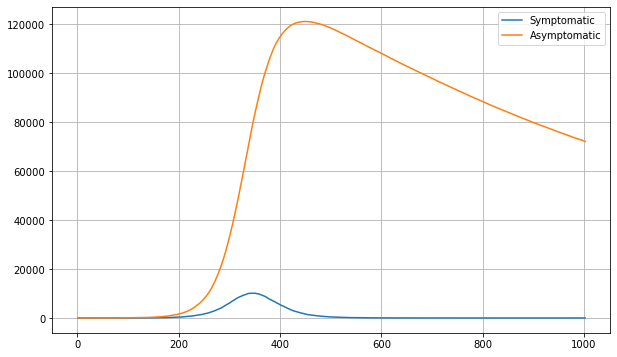

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(df['Day'], df['S'], label='Susceptible')
# ax.plot(df['Day'], df['E'], label='Exposed')
ax.plot(df_Central_High['Day'], df_Central_High['I'], label='Symptomatic')
ax.plot(df_Central_High['Day'], df_Central_High['A'], label='Asymptomatic')
# ax.plot(df['Day'], df['R'], label='Recovered')
ax.legend()
ax.grid()

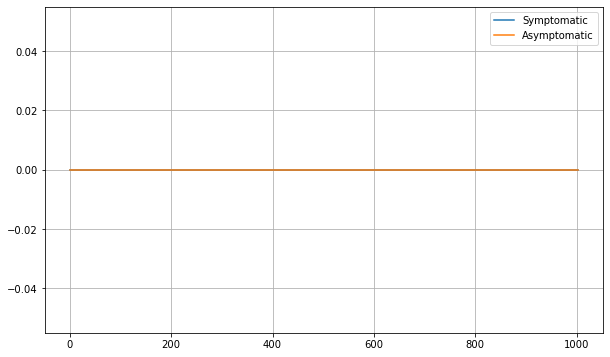

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_East_High['Day'], df_East_High['I'], label='Symptomatic')
ax.plot(df_East_High['Day'], df_East_High['A'], label='Asymptomatic')
ax.legend()
ax.grid()